# BRCA Subtype Association

In [1]:
import json as js
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib
from decimal import Decimal
import pymongo
import random
from sklearn.model_selection import train_test_split
from statsmodels.stats.multitest import fdrcorrection
from xgboost import XGBClassifier
import xgboost 
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
path = "/rumi/shams/jwang/TCGA_oncRNA"

## Load Metadata

In [3]:
tcga_metadata = pd.read_csv(f"{path}/metadata/TCGA_metadata.csv")
tcga_metadata = tcga_metadata.set_index("TCGAbarcode", drop=False)
clinical = pd.read_csv(f"{path}/metadata/combined_study_clinical_data.tsv", sep="\t", usecols=["Patient ID", "Sample ID", "Cancer Type Detailed", "Progression Free Status", "Progress Free Survival (Months)",
                              "Disease Free (Months)", "Disease Free Status", "Overall Survival Status", "Overall Survival (Months)",
                                "American Joint Committee on Cancer Tumor Stage Code", "Subtype"])


In [4]:
brca_clinical = clinical[clinical["Cancer Type Detailed"].str.contains("Breast")]
print(brca_clinical.shape)
brca_clinical.head(2)

(1084, 11)


,Patient ID,Sample ID,Cancer Type Detailed,Disease Free (Months),Disease Free Status,Overall Survival (Months),Overall Survival Status,American Joint Committee on Cancer Tumor Stage Code,Progress Free Survival (Months),Progression Free Status,Subtype
1469,TCGA-3C-AAAU,TCGA-3C-AAAU-01,Breast Invasive Lobular Carcinoma,59.440444,Recurred/Progressed,133.050597,LIVING,TX,59.440444,PROGRESSION,BRCA_LumA
1470,TCGA-3C-AALI,TCGA-3C-AALI-01,Breast Invasive Ductal Carcinoma,131.669790,DiseaseFree,131.669790,LIVING,T2,131.669790,CENSORED,BRCA_Her2


In [5]:
brca_clinical["Subtype"].unique()

array(['BRCA_LumA', 'BRCA_Her2', 'BRCA_LumB', 'BRCA_Normal', 'BRCA_Basal',
       nan], dtype=object)

In [6]:
brca_clinical = brca_clinical[~brca_clinical["Subtype"].isna()]
brca_clinical = brca_clinical[~brca_clinical["Subtype"].str.contains("Normal")]
brca_clinical.shape

(945, 11)

In [7]:
brca_metadata = tcga_metadata[(tcga_metadata["TSS"].str.contains("breast")) & (~tcga_metadata["Sample"].str.contains("normal"))].set_index("TCGAbarcode", drop=False)
brca_metadata["shortcode"] = brca_metadata["TCGAbarcode"].apply(lambda x: x[:15])
print(brca_metadata.shape)
brca_metadata.head(2)

(1103, 6)


,UUID,TCGAbarcode,TSS,Sample,TCGA_abb,shortcode
TCGAbarcode,,,,,,
TCGA-AO-A03L-01A-41R-A057-13,cc403178-7aa9-47ce-b80b-1019be418539,TCGA-AO-A03L-01A-41R-A057-13,breast invasive carcinoma,primary solid tumor,BRCA,TCGA-AO-A03L-01
TCGA-A2-A0CM-01A-31R-A035-13,4bfa3f47-d0f3-456a-b50b-2c277a58346c,TCGA-A2-A0CM-01A-31R-A035-13,breast invasive carcinoma,primary solid tumor,BRCA,TCGA-A2-A0CM-01


In [8]:
brca_merge = pd.merge(brca_metadata, brca_clinical, left_on="shortcode", right_on="Sample ID", how="inner")
brca_merge.shape

(946, 17)

In [9]:
len(brca_merge["shortcode"].unique()), len(brca_merge["TCGAbarcode"].unique())

(929, 946)

In [10]:
brca_subtype_map = dict(zip(list(brca_merge["Sample ID"]), list(brca_merge["Subtype"])))

## Load Data

In [11]:
sig_brca = pd.read_csv(f"{path}/results/fisher/post_filter/BRCA_fisher.filter.csv")
sig_brca = sig_brca[sig_brca["fdr"] <= 0.1].rename(columns={"Unnamed: 0":"RNA"})
sig_brca = sig_brca[~sig_brca["RNA"].str.contains("chrY")]
sig_brca = set(list(sig_brca["RNA"]))
len(sig_brca)

15404

In [12]:
myclient=pymongo.MongoClient(port=27027)
mydb = myclient["TCGA_loci"]
rnacol = mydb["oncRNA_fil"]
rnacol.estimated_document_count()

261479

In [13]:
brca_merge["Order"] = np.arange(946)
brca_dict_order = dict(zip(brca_merge["TCGAbarcode"], brca_merge["Order"]))
len(brca_dict_order)

946

In [ ]:
%%time
data = np.zeros((946, 15404))
binary_data = np.zeros((946, 15404))
cursor = rnacol.find(no_cursor_timeout=True)
oncRNA_order = []
j = 0
for rna in cursor:
    locus = rna["_id"]["locus"]
    if locus in sig_brca:
        oncRNA_order.append(locus)
        for s in rna["samples"]:
            barcode = s["study"]
            if barcode in brca_dict_order:
                i = brca_dict_order[barcode]
                data[i,j] = s["cpm"]
                binary_data[i,j] = 1
        j += 1
cursor.close()

## Subtype Association

In [15]:
subtype_count = brca_merge.groupby("Subtype", as_index=False).size()
subtype_count = dict(zip(subtype_count["Subtype"], subtype_count["size"]))
subtype_count

{'BRCA_Basal': 172, 'BRCA_Her2': 77, 'BRCA_LumA': 505, 'BRCA_LumB': 192}

In [16]:
data_df = pd.DataFrame(data, index=brca_merge["TCGAbarcode"].tolist(), columns=oncRNA_order)
binary_data_df = pd.DataFrame(binary_data, index=brca_merge["TCGAbarcode"].tolist(), columns=oncRNA_order)
data_df.head(1)

,chr10:100134991-100135028:-,chr10:100138905-100138944:-,chr10:10015672-10015696:+,chr10:100235703-100235855:-,chr10:100253527-100253587:-,chr10:100364990-100365017:+,chr10:100370693-100370722:-,chr10:100391303-100391333:-,chr10:10070820-10070851:+,chr10:100997630-100997660:-,...,chrX:9526578-9526686:+,chrX:96279106-96279144:+,chrX:96741097-96741117:+,chrX:97054922-97054944:-,chrX:97537064-97537086:-,chrX:97673665-97673699:-,chrX:97907929-97908083:+,chrX:97962395-97962416:-,chrX:98749971-98749993:+,chrX:99938983-99939017:-
TCGA-AO-A03L-01A-41R-A057-13,0.0,0.0,1.084704,0.0,0.0,0.542352,0.542352,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
pval_results = {}
for j in range(len(oncRNA_order)):
    rna = oncRNA_order[j]
    tumor_subtype_dict= {"BRCA_Basal":[], "BRCA_Her2":[], "BRCA_LumA":[], "BRCA_LumB":[]}  
    
    for i, barcode, subtype in zip(brca_merge["Order"], brca_merge["TCGAbarcode"], brca_merge["Subtype"]):
        tumor_subtype_dict[subtype].append(data[i,j])
    test = scipy.stats.f_oneway(tumor_subtype_dict["BRCA_Basal"], tumor_subtype_dict["BRCA_Her2"], tumor_subtype_dict["BRCA_LumA"], 
                                tumor_subtype_dict["BRCA_LumB"])
    pval_results[rna] = {"pval":test.pvalue, "data":tumor_subtype_dict}

In [18]:
pval_results_df = pd.DataFrame(pval_results).T
rej, fdr = fdrcorrection(pval_results_df["pval"], alpha=0.1)
pval_results_df["fdr"] = fdr  

In [19]:
sig_results = pval_results_df[pval_results_df["fdr"] <= 0.001].sort_values("fdr")
print(sig_results.shape)
sig_results.head()

(910, 3)


,pval,data,fdr
chr17:39676145-39676175:-,0.0,"{'BRCA_Basal': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
chr16:48177980-48178031:-,0.0,"{'BRCA_Basal': [0.0, 0.0, 0.0, 0.2915547096581...",0.0
chr14:71907472-71907534:+,0.0,"{'BRCA_Basal': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
chr15:99144555-99144586:+,0.0,"{'BRCA_Basal': [0.5938132967861043, 0.0, 0.147...",0.0
chr3:119320656-119320706:-,0.0,"{'BRCA_Basal': [0.5938132967861043, 0.0, 0.0, ...",0.0


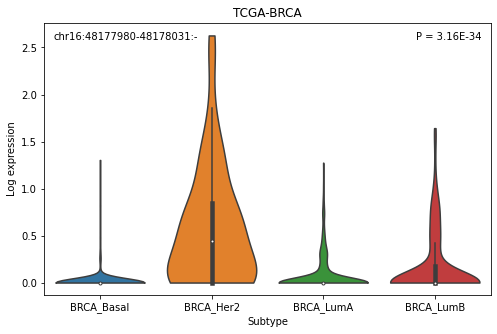

In [20]:
plt.figure(figsize=(8,5))
rna = sig_results.index[1]
tumor_subtype_dict = sig_results.loc[rna]["data"]
pval = sig_results.loc[rna]["pval"]
exp_data = []
subtype_data = []
order = ["BRCA_Basal", "BRCA_Her2", "BRCA_LumA", "BRCA_LumB"]
for subtype in order:
    exp_data.extend(tumor_subtype_dict[subtype])
    subtype_data.extend([subtype]*len(tumor_subtype_dict[subtype]))
data = pd.DataFrame(subtype_data, columns=["Subtype"])
data["RNA expression"] = exp_data
data["Log expression"] = np.log(data["RNA expression"] + 1)
sns.violinplot(x="Subtype", y="Log expression", data=data, scale="width", inner="box", cut=0) #Scale by width
plt.title("TCGA-BRCA")
ax = plt.gca()
ax.add_artist(AnchoredText(f"P = {'%.2E' % Decimal(pval)}", frameon=False, 
                            loc='upper right'))
ax.add_artist(AnchoredText(f"{rna}", frameon=False, 
                            loc='upper left'))
plt.savefig(f"{path}/figures/subtypes/brca_subtype_assoc_oncRNA1.pdf")

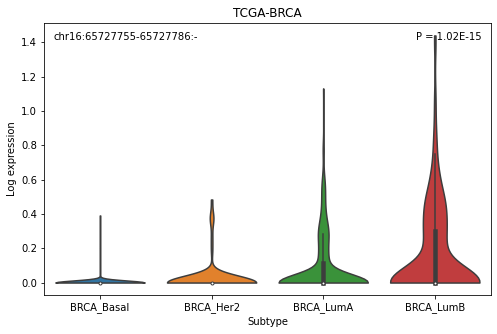

In [21]:
plt.figure(figsize=(8,5))
rna = sig_results.index[38]
tumor_subtype_dict = sig_results.loc[rna]["data"]
pval = sig_results.loc[rna]["pval"]
exp_data = []
subtype_data = []
order = ["BRCA_Basal", "BRCA_Her2", "BRCA_LumA", "BRCA_LumB"]
for subtype in order:
    exp_data.extend(tumor_subtype_dict[subtype])
    subtype_data.extend([subtype]*len(tumor_subtype_dict[subtype]))
data = pd.DataFrame(subtype_data, columns=["Subtype"])
data["RNA expression"] = exp_data
data["Log expression"] = np.log(data["RNA expression"] + 1)
sns.violinplot(x="Subtype", y="Log expression", data=data, scale="width", inner="box", cut=0)
plt.title("TCGA-BRCA")
ax = plt.gca()
ax.add_artist(AnchoredText(f"P = {'%.2E' % Decimal(pval)}", frameon=False, 
                            loc='upper right'))
ax.add_artist(AnchoredText(f"{rna}", frameon=False, 
                            loc='upper left'))
plt.savefig(f"{path}/figures/subtypes/brca_subtype_assoc_oncRNA2.pdf")

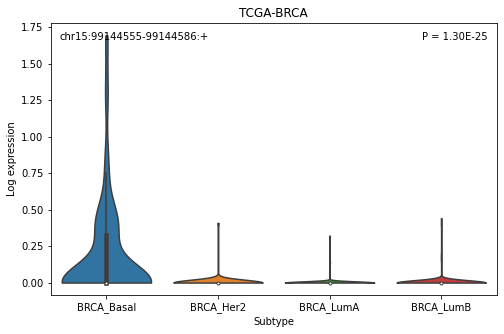

In [22]:
plt.figure(figsize=(8,5))
rna = sig_results.index[3]
tumor_subtype_dict = sig_results.loc[rna]["data"]
pval = sig_results.loc[rna]["pval"]
exp_data = []
subtype_data = []
order = ["BRCA_Basal", "BRCA_Her2", "BRCA_LumA", "BRCA_LumB"]
for subtype in order:
    exp_data.extend(tumor_subtype_dict[subtype])
    subtype_data.extend([subtype]*len(tumor_subtype_dict[subtype]))
data = pd.DataFrame(subtype_data, columns=["Subtype"])
data["RNA expression"] = exp_data
data["Log expression"] = np.log(data["RNA expression"] + 1)
sns.violinplot(x="Subtype", y="Log expression", data=data, scale="width", inner="box", cut=0)
plt.title("TCGA-BRCA")
ax = plt.gca()
ax.add_artist(AnchoredText(f"P = {'%.2E' % Decimal(pval)}", frameon=False, 
                            loc='upper right'))
ax.add_artist(AnchoredText(f"{rna}", frameon=False, 
                            loc='upper left'))
plt.savefig(f"{path}/figures/subtypes/brca_subtype_assoc_oncRNA3.pdf")

# Heatmap

In [23]:
sig_oncRNAs = data_df[sig_results.index].T
print(sig_oncRNAs.shape)
sig_oncRNAs.head()

(910, 946)


,TCGA-AO-A03L-01A-41R-A057-13,TCGA-A2-A0CM-01A-31R-A035-13,TCGA-OL-A5RX-01A-11R-A28I-13,TCGA-AR-A5QN-01A-12R-A28I-13,TCGA-AR-A1AX-01A-11R-A12O-13,TCGA-AR-A5QP-01A-11R-A28I-13,TCGA-PE-A5DD-01A-12R-A27U-13,TCGA-E9-A5FK-01A-11R-A27U-13,TCGA-A2-A04U-01A-11R-A114-13,TCGA-E9-A1NH-01A-11R-A14C-13,...,TCGA-B6-A0I5-01A-11R-A035-13,TCGA-A7-A0CE-01A-11R-A010-13,TCGA-A2-A04T-01A-21R-A035-13,TCGA-BH-A0DS-01A-11R-A057-13,TCGA-AO-A12H-01A-11R-A114-13,TCGA-LL-A5YM-01A-11R-A28I-13,TCGA-BH-A18M-01A-11R-A12C-13,TCGA-E9-A22H-01A-11R-A156-13,TCGA-A1-A0SO-01A-22R-A085-13,TCGA-C8-A12N-01A-11R-A114-13
chr17:39676145-39676175:-,0.0,0.000000,0.000000,0.000000,0.0,0.094118,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
chr16:48177980-48178031:-,0.0,0.000000,0.234310,0.000000,0.0,0.000000,0.0,0.0,0.0,0.869779,...,0.600934,0.0,0.0,0.0,0.315303,0.000000,0.0,0.175662,0.000000,0.0
chr14:71907472-71907534:+,0.0,0.000000,0.000000,0.092127,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
chr15:99144555-99144586:+,0.0,0.593813,0.117155,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
chr3:119320656-119320706:-,0.0,0.593813,0.000000,0.000000,0.0,0.094118,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.429435,0.0,0.000000,2.820919,0.0


In [24]:
colData = pd.DataFrame(sig_oncRNAs.columns, columns=["Sample"]) #Sample column contains all the samples
colData["Subtype"] = brca_merge["Subtype"].tolist()
colData = colData.sort_values("Subtype") #First sort by cell line then by subtype
colData = colData.set_index("Subtype", drop=False)
colors = sns.color_palette("Paired", len(colData["Subtype"].unique()))
random.shuffle(colors)
lut = dict(zip(list(colData["Subtype"].unique()), colors))
col_colors = colData["Subtype"].map(lut)

In [25]:
colData

,Sample,Subtype
Subtype,,
BRCA_Basal,TCGA-AR-A1AQ-01A-11R-A12O-13,BRCA_Basal
BRCA_Basal,TCGA-AC-A2BK-01A-11R-A21U-13,BRCA_Basal
BRCA_Basal,TCGA-E2-A14X-01A-11R-A114-13,BRCA_Basal
BRCA_Basal,TCGA-A2-A25F-01A-11R-A168-13,BRCA_Basal
BRCA_Basal,TCGA-AR-A0TP-01A-11R-A085-13,BRCA_Basal
...,...,...
BRCA_LumB,TCGA-A8-A09I-01A-22R-A035-13,BRCA_LumB
BRCA_LumB,TCGA-A2-A0YT-01A-11R-A108-13,BRCA_LumB
BRCA_LumB,TCGA-A2-A0EY-01A-11R-A035-13,BRCA_LumB


In [26]:
#Max norm
loci_df = np.zeros(sig_oncRNAs.shape)
for i in range(sig_oncRNAs.shape[0]):
    percentile = 97
    max_per_row = np.percentile(sig_oncRNAs.iloc[i], percentile)
    while max_per_row == 0:
        percentile += 1
        max_per_row = np.percentile(sig_oncRNAs.iloc[i], percentile) 
    loci_df[i] = np.divide(sig_oncRNAs.iloc[i], max_per_row) #Max-norm

In [27]:
loci_df = pd.DataFrame(loci_df, index=sig_oncRNAs.index, columns=sig_oncRNAs.columns)
loci_df = loci_df[list(colData["Sample"])] #Set columns to match colData order
loci_df.columns = colData["Subtype"]

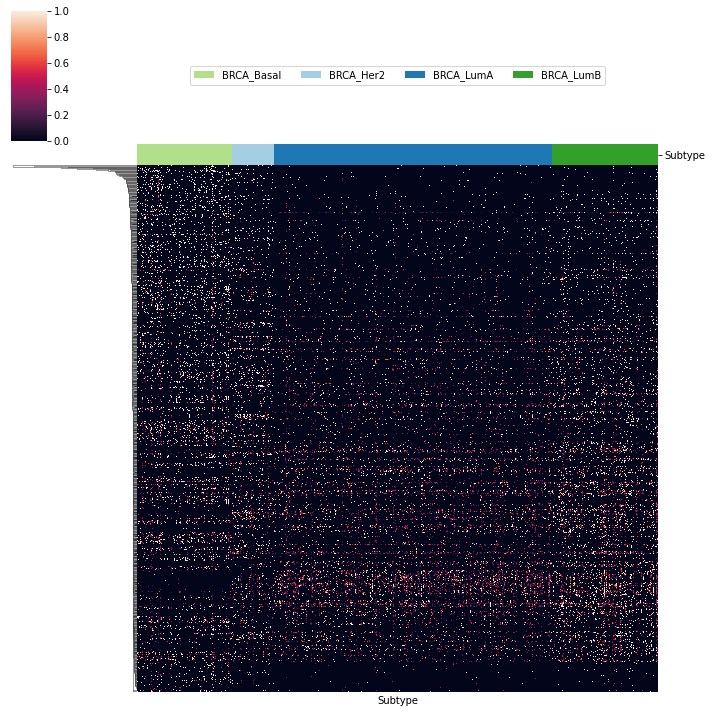

In [28]:
g=sns.clustermap(loci_df,figsize=(10,10), col_cluster=False, row_cluster=True, col_colors=col_colors, yticklabels=False, xticklabels=False, metric='euclidean', method="average", rasterized=True, vmax=1)
for label in colData["Subtype"].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=5)
g.savefig(f"{path}/figures/subtypes/brca_subtypes_cpm_heatmap.pdf")

### Binary

In [29]:
binary_df = binary_data_df[sig_results.index].T
print(binary_df.shape)
binary_df.head(2)

(910, 946)


,TCGA-AO-A03L-01A-41R-A057-13,TCGA-A2-A0CM-01A-31R-A035-13,TCGA-OL-A5RX-01A-11R-A28I-13,TCGA-AR-A5QN-01A-12R-A28I-13,TCGA-AR-A1AX-01A-11R-A12O-13,TCGA-AR-A5QP-01A-11R-A28I-13,TCGA-PE-A5DD-01A-12R-A27U-13,TCGA-E9-A5FK-01A-11R-A27U-13,TCGA-A2-A04U-01A-11R-A114-13,TCGA-E9-A1NH-01A-11R-A14C-13,...,TCGA-B6-A0I5-01A-11R-A035-13,TCGA-A7-A0CE-01A-11R-A010-13,TCGA-A2-A04T-01A-21R-A035-13,TCGA-BH-A0DS-01A-11R-A057-13,TCGA-AO-A12H-01A-11R-A114-13,TCGA-LL-A5YM-01A-11R-A28I-13,TCGA-BH-A18M-01A-11R-A12C-13,TCGA-E9-A22H-01A-11R-A156-13,TCGA-A1-A0SO-01A-22R-A085-13,TCGA-C8-A12N-01A-11R-A114-13
chr17:39676145-39676175:-,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr16:48177980-48178031:-,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [30]:
binary_df = binary_df[list(colData["Sample"])] #Set columns to match colData order
binary_df.columns = colData["Subtype"]

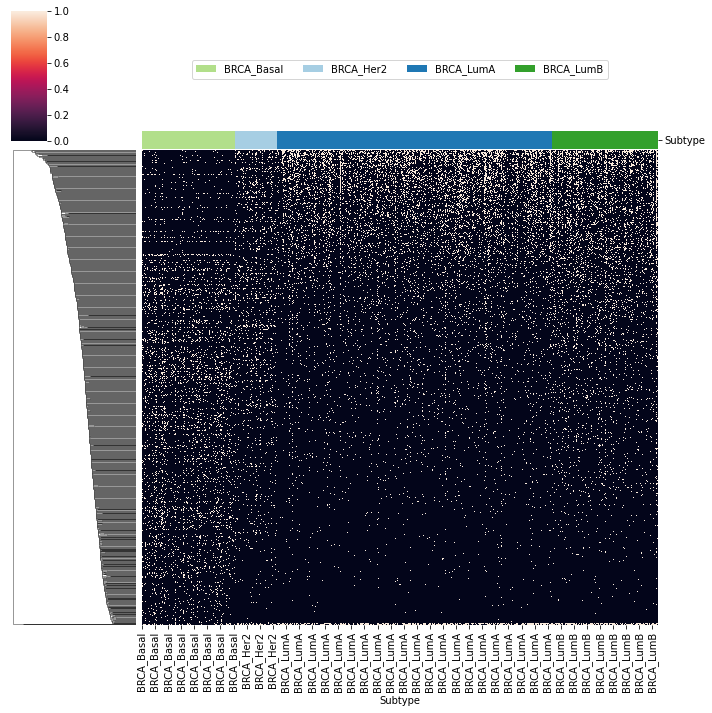

In [31]:
g=sns.clustermap(binary_df,figsize=(10,10), col_cluster=False, row_cluster=True, col_colors=col_colors,yticklabels=False, rasterized=True)
for label in colData["Subtype"].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=5)
g.savefig(f"{path}/figures/subtypes/brca_subtypes_binary_heatmap.pdf")

# Classifier

In [32]:
X = data_df[loci_df.index].apply(np.ceil)
Y = []
for barcode in X.index:
    short_code = barcode[:15]
    Y.append(brca_subtype_map[short_code])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, stratify=Y)

In [34]:
labels = np.unique(Y)
class_weights = class_weight.compute_class_weight("balanced", labels, y_train)
class_weight_map = {}
for i in range(len(labels)):
    class_weight_map[labels[i]] = class_weights[i] 
sample_weights = []
for y in y_train:
    sample_weights.append(class_weight_map[y])

In [35]:
xgb_model = XGBClassifier(silent=False,n_estimators=100, random_state=37, max_depth=3)
xgb_model.fit(X_train, y_train)

[20:17:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=37, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, silent=False, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
y_pred = xgb_model.predict(X_train)
acc = accuracy_score(y_train, y_pred)      
acc

1.0

In [37]:
y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)      
acc

0.7947368421052632

In [38]:
y_pred = xgb_model.predict(X_test)

In [39]:
print(classification_report(y_pred, y_test, labels=labels))

              precision    recall  f1-score   support

  BRCA_Basal       0.91      0.94      0.93        34
   BRCA_Her2       0.40      0.86      0.55         7
   BRCA_LumA       0.93      0.80      0.86       118
   BRCA_LumB       0.49      0.61      0.54        31

    accuracy                           0.79       190
   macro avg       0.68      0.80      0.72       190
weighted avg       0.84      0.79      0.81       190



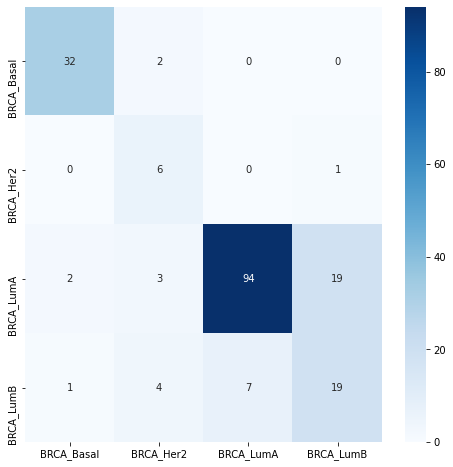

In [41]:
cm = confusion_matrix(y_pred, y_test, labels=labels)
cm = np.around(cm, 3)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.savefig(f"{path}/figures/subtypes/brca_subtype_cm.pdf")

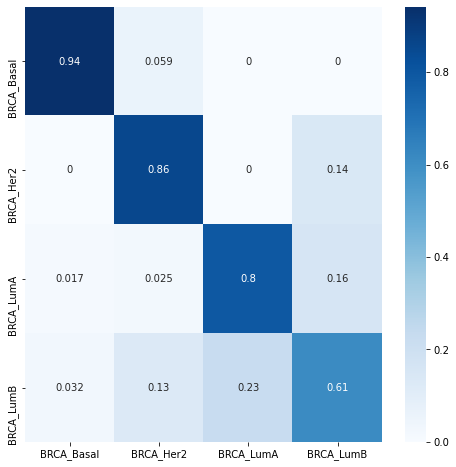

In [42]:
row_norm_cm = confusion_matrix(y_pred, y_test, labels=labels, normalize="true") #Normalizes by True rows (measure of precision)
row_norm_cm = np.around(row_norm_cm, 3)
plt.figure(figsize=(8,8))
sns.heatmap(row_norm_cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.savefig(f"{path}/figures/subtypes/brca_subtypes_cm_row.pdf")

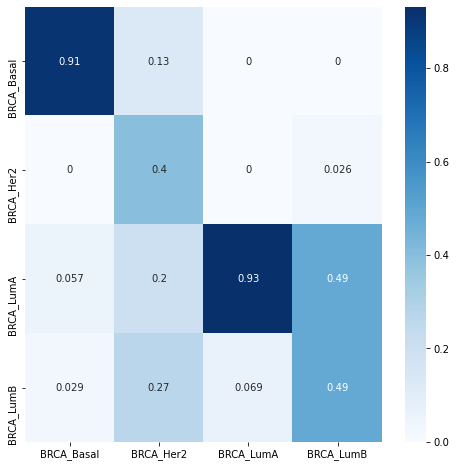

In [43]:
norm_cm = confusion_matrix(y_pred, y_test, labels=labels, normalize="pred")
norm_cm = np.around(norm_cm, 3)
plt.figure(figsize=(8,8))
sns.heatmap(norm_cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.savefig(f"{path}/figures/subtypes/brca_subtypes_cm_col.pdf")

A little less concerned after finding that normal-like breast cancer is similar to luminal A disease: hormone-receptor positive (estrogen-receptor and/or progesterone-receptor positive), HER2 negative, and has low levels of the protein Ki-67, which helps control how fast cancer cells grow. Still, while normal-like breast cancer has a good prognosis, its prognosis is slightly worse than luminal A cancer’s prognosis.
Source: https://www.breastcancer.org/symptoms/types/molecular-subtypes

# Done